In [47]:
#create_dual_candlestick_plot(data):
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns


def create_candlestick_grid(data_list, rows, cols, filename='candlestick_grid.png'):
    sns.set(style="whitegrid")

    # Calculate figure size for office paper (8.5 x 11 inches) at 300 DPI
    fig_width = 8.5
    fig_height = 11
    dpi = 300

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height), dpi=dpi)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    for ax, data in zip(axes, data_list):
        # Convert timestamp to datetime
        data = data.copy()
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
        
        # Prepare data for candlestick plotting
        btc_data = data[['timestamp', 'open (BTC)', 'high (BTC)', 'low (BTC)', 'close (BTC)']].copy()
        eth_data = data[['timestamp', 'open (ETH)', 'high (ETH)', 'low (ETH)', 'close (ETH)']].copy()
        
        # Convert timestamp to Matplotlib date format
        btc_data['timestamp'] = btc_data['timestamp'].apply(mdates.date2num)
        eth_data['timestamp'] = eth_data['timestamp'].apply(mdates.date2num)
        
        # Plot BTC candlestick chart
        candlestick_ohlc(ax, btc_data.values, width=0.01, colorup='green', colordown='red')
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_title('BTC-USD')
        ax.set_ylabel('Price (BTC)')
        ax.set_xlabel('Time')
        plt.xticks(rotation=45)

        # Plot ETH candlestick chart
        candlestick_ohlc(ax, eth_data.values, width=0.01, colorup='blue', colordown='orange')
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_title('ETH-USD')
        ax.set_ylabel('Price (ETH)')
        ax.set_xlabel('Time')
        plt.xticks(rotation=45)
    
    # Hide any remaining empty subplots
    for i in range(len(data_list), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    

def create_dual_candlestick_plot(data):
    # Convert timestamp to datetime
    data = data.copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Prepare data for candlestick plotting
    btc_data = data[['timestamp', 'open (BTC)', 'high (BTC)', 'low (BTC)', 'close (BTC)']].copy()
    eth_data = data[['timestamp', 'open (ETH)', 'high (ETH)', 'low (ETH)', 'close (ETH)']].copy()
    
    # Convert timestamp to Matplotlib date format
    btc_data['timestamp'] = btc_data['timestamp'].apply(mdates.date2num)
    eth_data['timestamp'] = eth_data['timestamp'].apply(mdates.date2num)
    
    sns.set(style="darkgrid")
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)
    
    # Plot BTC candlestick chart
    candlestick_ohlc(ax1, btc_data.values, width=0.01, colorup='green', colordown='red')
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax1.set_title('BTC-USD Candlestick Chart')
    ax1.set_ylabel('Price (BTC)')
    
    # Plot ETH candlestick chart
    candlestick_ohlc(ax2, eth_data.values, width=0.01, colorup='blue', colordown='orange')
    ax2.xaxis_date()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax2.set_title('ETH-USD Candlestick Chart')
    ax2.set_ylabel('Price (ETH)')
    ax2.set_xlabel('Timestamp')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [30]:
#get_market_data_for_symbols(list_of_symbols, timeframe):
import pandas as pd
from data_service import DataService


def get_market_data_for_symbols(list_of_symbols, timeframe):
    """queries all marketdata available in database for the selected symbols and timeframe

    Each series name includes symbol

        params:
            list_of_symbols: format like 'ETH-USDT'
            timeframe: format like '1min'

        return: list of marketdata dataframes, last element is merged dataframes
    """
    dataframes = []
    for symbol in list_of_symbols:
        df = DataService(symbol, timeframe).load_market_data()
        df.columns = [col + f" ({symbol.split("-")[0]})" if col != "timestamp" else col for col in df.columns]
        dataframes.append(df)
    
    for i in range(len(dataframes) - 1):
        df = pd.merge(df, dataframes[i], on='timestamp', how='inner')
    dataframes.append(df)
    return dataframes

In [50]:
#get_previous_candles(data, window_size=45):
def get_previous_candles(data, window_size=45):
    dataframes = []
    # Find the indices where 'wins' column is 1
    win_indices = data.index[data['win'] == 1].tolist()
    
    for idx in win_indices:
        if idx >= window_size:
            # Extract the previous 45 rows excluding the originating row
            df = data.iloc[idx - window_size:idx].copy()
            dataframes.append(df)
    
    return dataframes


In [51]:
#get_following_candles(data, window_size=45):
def get_following_candles(data, window_size=45):
    dataframes = []
    # Find the indices where 'wins' column is 1
    win_indices = data.index[data['wins'] == 1].tolist()
    
    for idx in win_indices:
        # Ensure there are enough rows after the current index
        if idx + 1 + window_size <= len(data):
            # Extract the following 45 rows, excluding the originating row, and make a copy to avoid SettingWithCopyWarning
            df = data.iloc[idx + 1:idx + 1 + window_size].copy()
            dataframes.append(df)
    
    return dataframes

In [33]:
# get market data for multiple symbols
df = get_market_data_for_symbols(['ETH-USDT', 'BTC-USDT'], "3min")[-1]
display(df.columns)


Index(['id (BTC)', 'timestamp', 'open (BTC)', 'close (BTC)', 'high (BTC)',
       'low (BTC)', 'volume (BTC)', 'amount (BTC)', 'symbol (BTC)',
       'timeframe (BTC)', 'id (ETH)', 'open (ETH)', 'close (ETH)',
       'high (ETH)', 'low (ETH)', 'volume (ETH)', 'amount (ETH)',
       'symbol (ETH)', 'timeframe (ETH)'],
      dtype='object')

In [34]:
# drop cols
drop_cols = [col for col in df.columns 
           if 'id (' in col 
           or 'symbol (' in col 
           or 'timeframe (' in col]

df = df.drop(drop_cols, axis=1)
display(df)

,timestamp,open (BTC),close (BTC),high (BTC),low (BTC),volume (BTC),amount (BTC),open (ETH),close (ETH),high (ETH),low (ETH),volume (ETH),amount (ETH)
0,1627388460,37921.8,37993.0,38005.0,37921.7,12.430279,472068.436372,2269.54,2273.66,2275.24,2269.10,202.926697,461190.490193
1,1627388640,37992.9,37981.3,38069.1,37953.0,7.152814,271949.237565,2273.35,2272.92,2277.08,2271.57,70.050489,159372.123758
2,1627388820,37976.0,37989.6,38015.3,37963.3,5.819570,221064.718963,2272.18,2272.46,2275.39,2271.00,30.162256,68543.216371
3,1627389000,37990.9,38081.1,38148.0,37956.4,14.301592,544326.172536,2272.04,2277.76,2281.25,2270.61,80.891352,184225.258406
4,1627389180,38080.4,38252.7,38260.0,38074.8,21.509973,821417.451089,2277.76,2288.81,2289.50,2277.69,233.528651,533500.292762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499279,1717258680,67661.9,67651.6,67661.9,67617.4,0.992349,67116.679561,3797.02,3797.31,3798.36,3794.15,33.293991,126396.428656
499280,1717258860,67651.5,67697.4,67702.7,67651.5,1.257906,85138.234531,3797.65,3798.00,3800.91,3797.65,31.610752,120110.356425
499281,1717259040,67695.2,67707.2,67707.2,67680.8,0.399566,27047.434768,3798.34,3801.87,3801.87,3797.31,16.853405,64026.894622
499282,1717259220,67707.2,67713.6,67713.6,67707.1,1.059070,71711.811459,3801.86,3804.10,3804.59,3801.86,10.593988,40287.996050


In [35]:
# find wins
from labeler import BinaryWinFinder 
win_finder = BinaryWinFinder(df, "ETH-USDT", "long", 40, 0.01)
df['win'] = win_finder.find_wins()

In [36]:
display(df)

,timestamp,open (BTC),close (BTC),high (BTC),low (BTC),volume (BTC),amount (BTC),open (ETH),close (ETH),high (ETH),low (ETH),volume (ETH),amount (ETH),win
0,1627388460,37921.8,37993.0,38005.0,37921.7,12.430279,472068.436372,2269.54,2273.66,2275.24,2269.10,202.926697,461190.490193,1
1,1627388640,37992.9,37981.3,38069.1,37953.0,7.152814,271949.237565,2273.35,2272.92,2277.08,2271.57,70.050489,159372.123758,1
2,1627388820,37976.0,37989.6,38015.3,37963.3,5.819570,221064.718963,2272.18,2272.46,2275.39,2271.00,30.162256,68543.216371,1
3,1627389000,37990.9,38081.1,38148.0,37956.4,14.301592,544326.172536,2272.04,2277.76,2281.25,2270.61,80.891352,184225.258406,1
4,1627389180,38080.4,38252.7,38260.0,38074.8,21.509973,821417.451089,2277.76,2288.81,2289.50,2277.69,233.528651,533500.292762,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499279,1717258680,67661.9,67651.6,67661.9,67617.4,0.992349,67116.679561,3797.02,3797.31,3798.36,3794.15,33.293991,126396.428656,0
499280,1717258860,67651.5,67697.4,67702.7,67651.5,1.257906,85138.234531,3797.65,3798.00,3800.91,3797.65,31.610752,120110.356425,0
499281,1717259040,67695.2,67707.2,67707.2,67680.8,0.399566,27047.434768,3798.34,3801.87,3801.87,3797.31,16.853405,64026.894622,0
499282,1717259220,67707.2,67713.6,67713.6,67707.1,1.059070,71711.811459,3801.86,3804.10,3804.59,3801.86,10.593988,40287.996050,0


In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler


In [52]:
wins = get_previous_candles(df)

KeyError: 'wins'

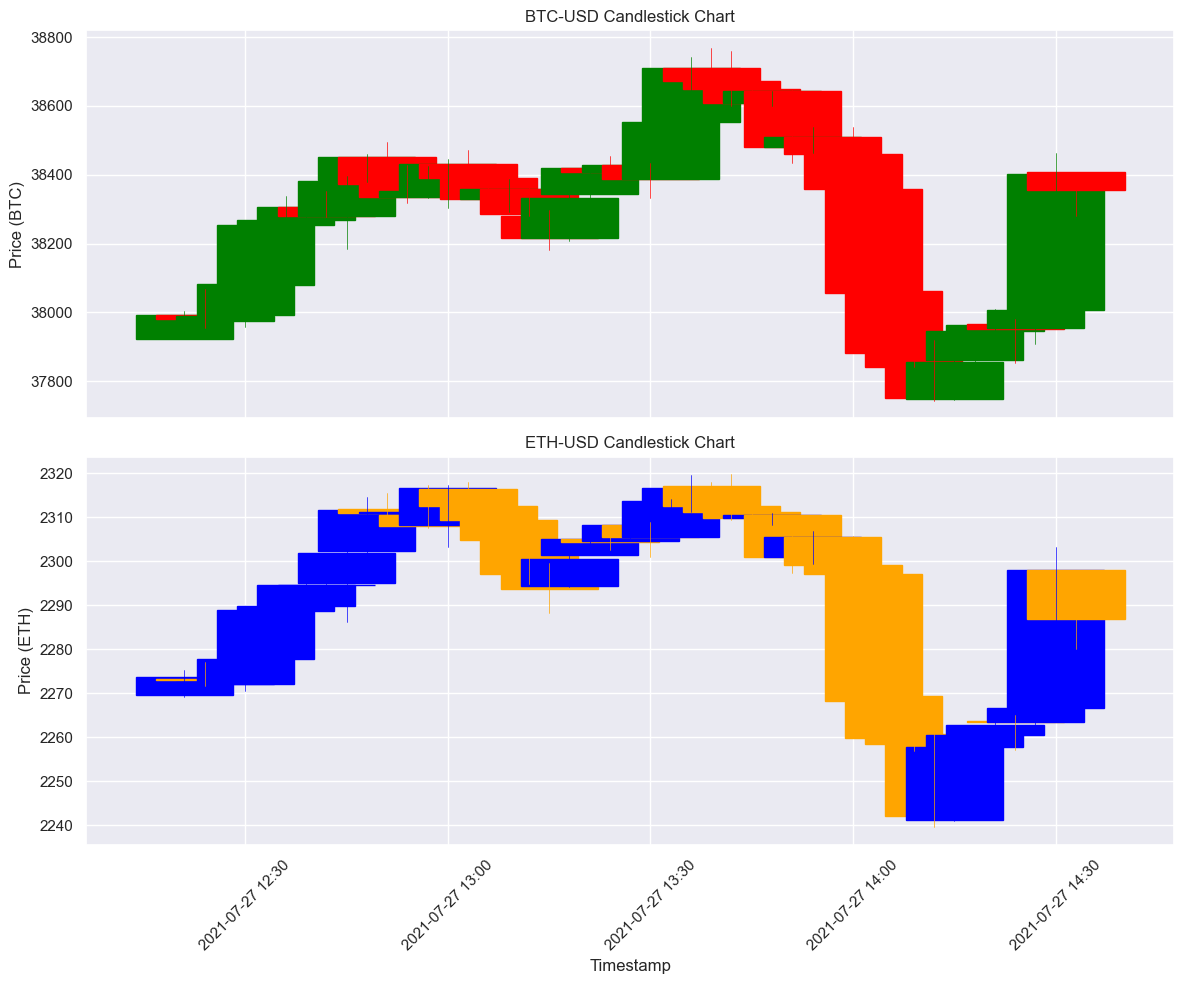

In [46]:
create_dual_candlestick_plot(wins[0])

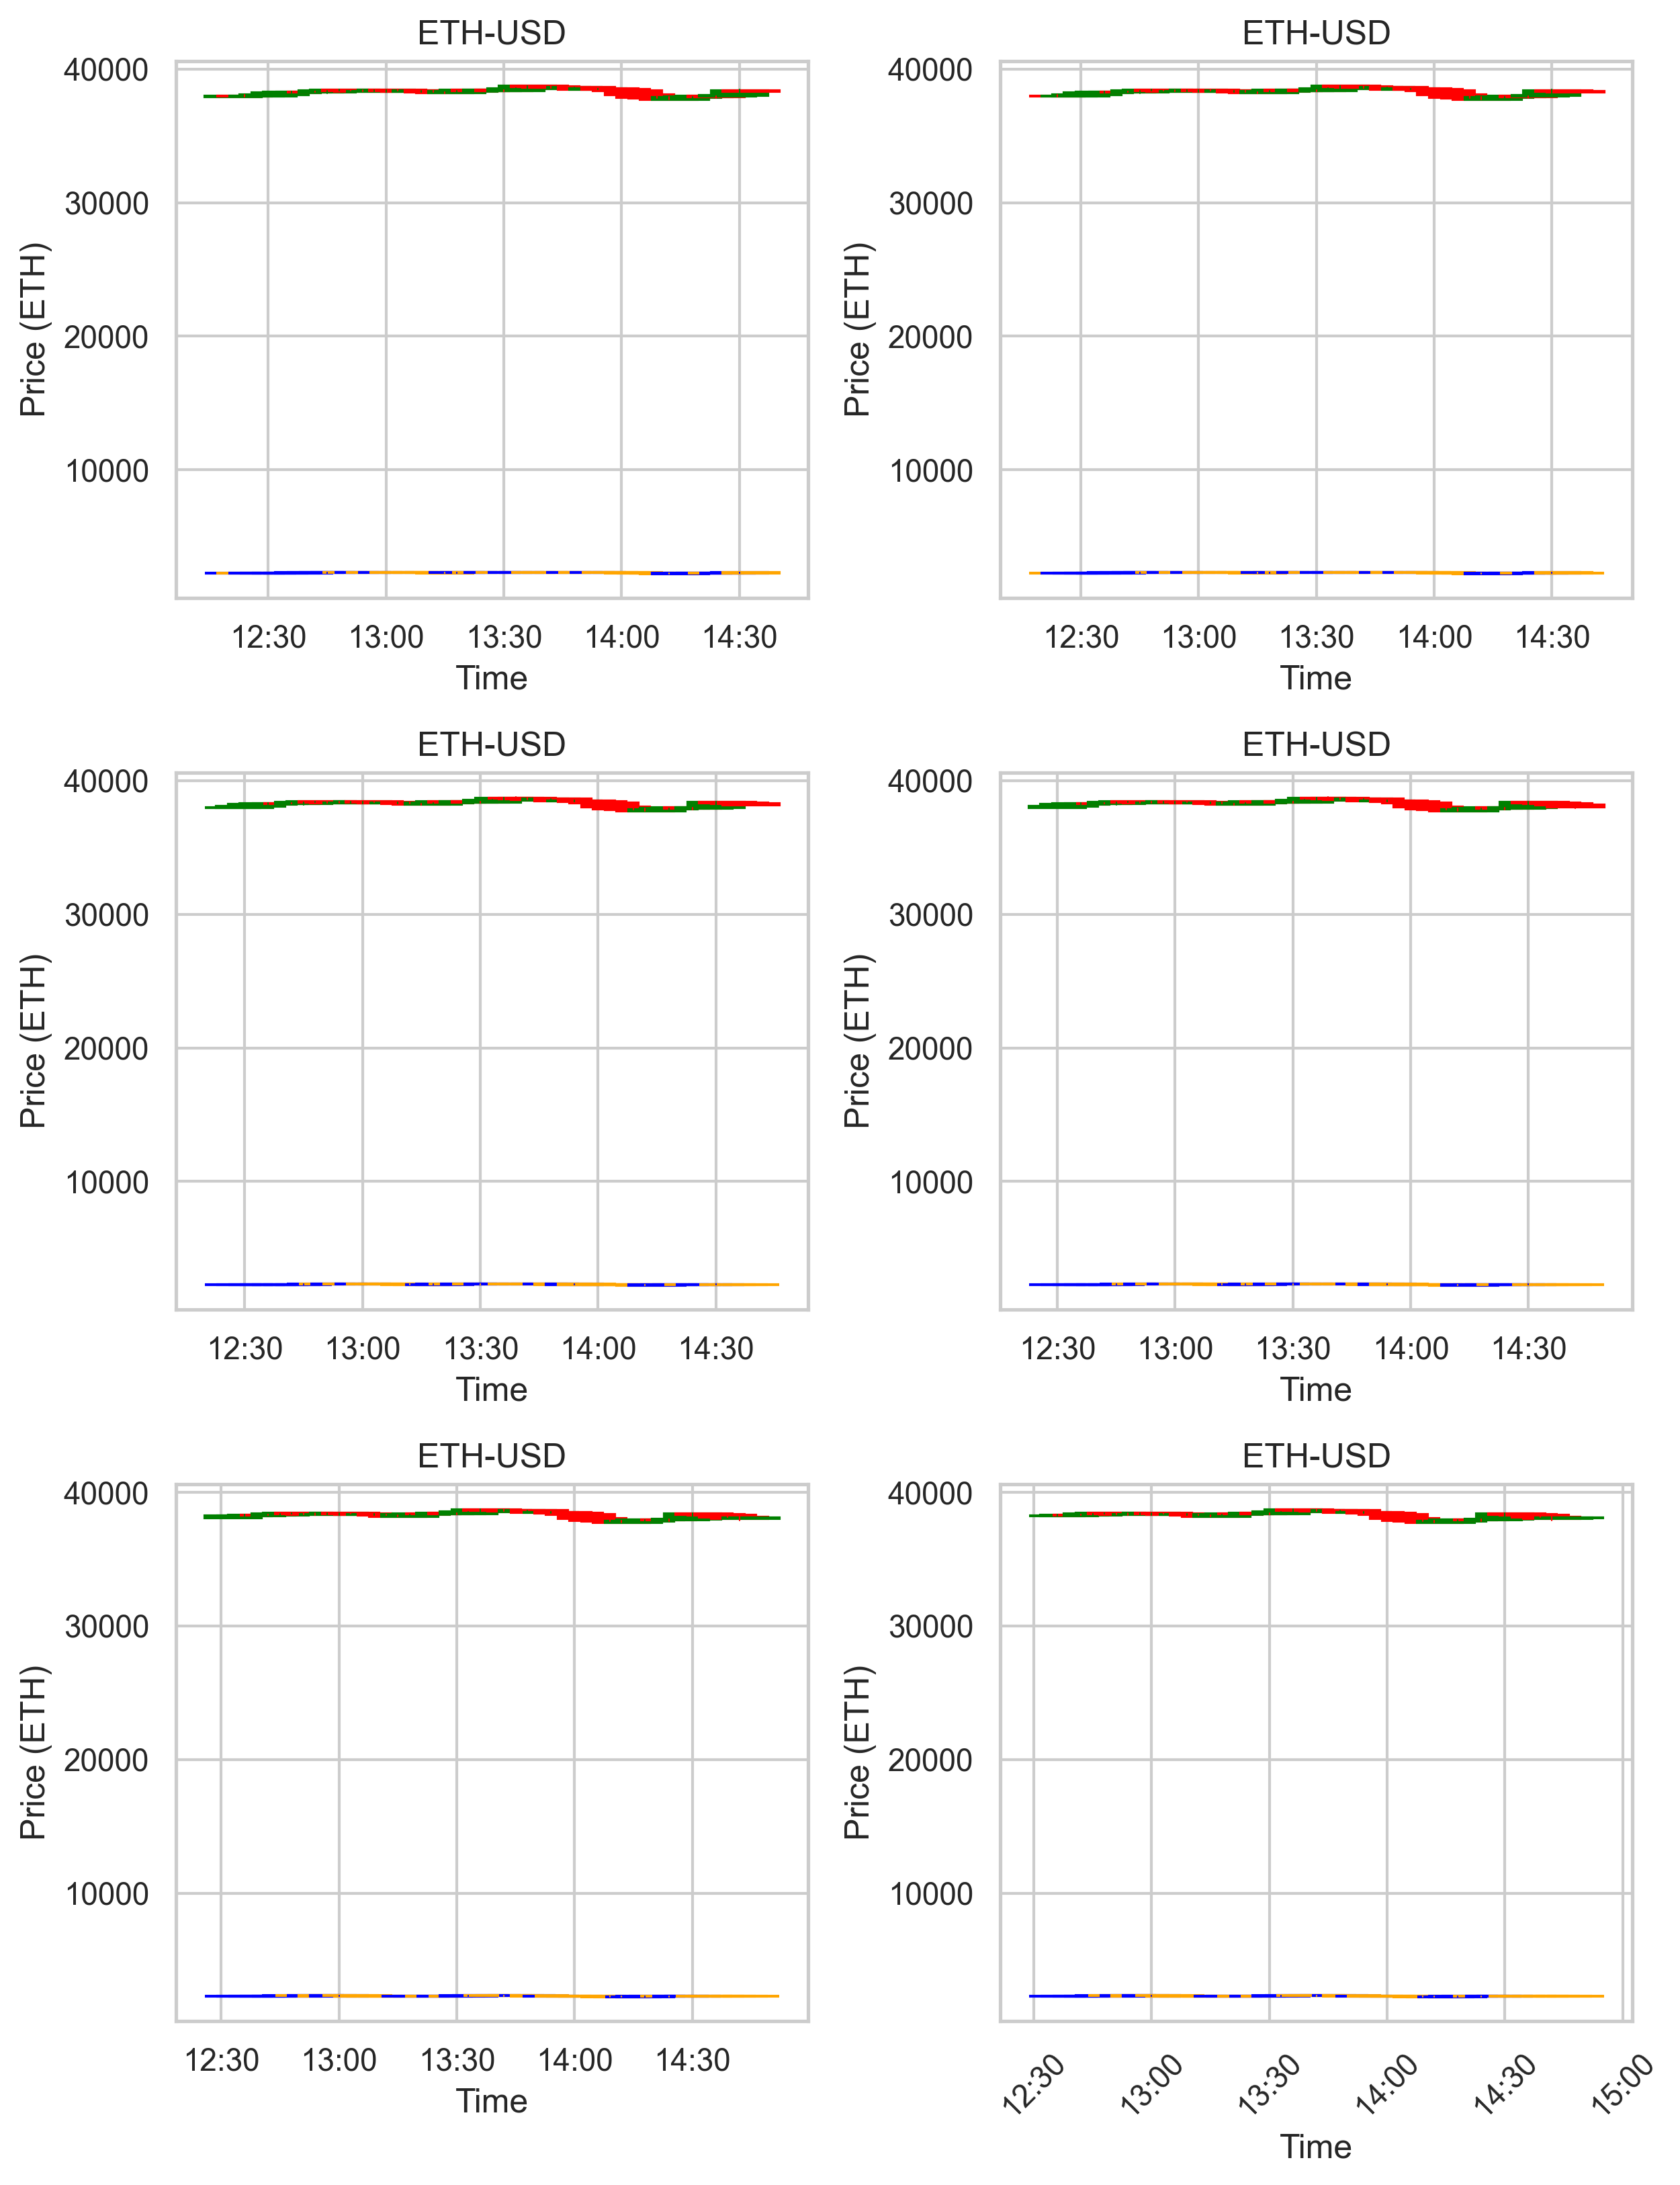

In [49]:
create_candlestick_grid(wins, 3, 2)